### Author: Eitan Vilker

### Genome-scale FBA models using CobraPy


##Installation of **cobrapy**
Main page: https://opencobra.github.io/cobrapy/

Full documentation: https://cobrapy.readthedocs.io/en/latest/index.html

In [ ]:
# Install cobrapy library
!pip install cobra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 27.3 MB/s eta 0:00:00


##Import Libraries

Import libraries used in following scripts, including the cobrapy library

In [ ]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cobra
from cobra.flux_analysis import flux_variability_analysis
import seaborn as sns # Imports Library for drawing heatmaps
import time

In [ ]:
# prompt: load my google drive and access the file "MyDrive/Segre_Final_Project/iBreastCancer1771.xml"
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
file_path = '/content/gdrive/MyDrive/BiologicalNetworks/Recon3D.json'

## Uploading a model into colab & cobrapy

The following function is just a convenient script we can use to upload models in different formats. It detects automatically the format from the file name, and uses the appropriate cobrapy built-in function. The three key formats are:

1. **.xml** - this is the standard model file in SBML (Systems Biology Markup Language). In the past there used to be different variants of SBML notation for FBA models. One may need to use some caution with older xml files.

2. **.mat** - this is the Matlab format, used in the original COBRA Toolbox built for Matlab. It is convenient to use if ones want to switch back and forth between Matlab and Python.

3. **.json** - json file, I think this is meant to be the standard in cobrapy.

In [ ]:
# UNIVERSAL MODEL UPLOAD FUNCTION
# This function detects automatically the format of a model and uploads it using cobrapy
# Possible formats: .mat, json, .xml
def read_model(_file_name):
  suffix = _file_name.split('.')[-1]
  print("Uploading model of type: ",suffix)
  if (suffix == 'xml'):
    _model = cobra.io.read_sbml_model(_file_name)
  elif (suffix == 'mat'):
    _model = cobra.io.load_matlab_model(_file_name)
  elif (suffix == 'json'):
    _model = cobra.io.load_json_model(_file_name)
  else:
    print("MODEL OF UNKNOWN TYPE")
    _model='UNKNOWN'
  n = len(_model.reactions)
  m = len(_model.metabolites)
  print("Number of reactions = ",len(_model.reactions))
  print("Number of metabolites = ",len(_model.metabolites))
  print("Number of genes = ",len(_model.genes))
  return _model


In [ ]:
model = read_model(file_path)

Uploading model of type:  json
Number of reactions =  10600
Number of metabolites =  5835
Number of genes =  2248


The following script is just one of the ways to import files from your hard drive into colab. It will ask you to look for the local file you want to upload and use for modeling. Click "Choose File", etc.

Now you can use the universal model upload function with the file imported into colab from your directory.

## Display/Modify properties of current model

Convenient cobrapy function to display basic properties of imported model. NOTE: I believe this function also run FBA to dsiplay fluxes under default conditions, if feasible.

In [ ]:
hits = model.reactions.query("Decaprenyl-diphosphate synthase subunit 2", attribute="name")
fh   = hits[0]        # first (and usually only) match

IndexError: list index out of range

Some useful scripts to check what the model is doing, and visualize the stoichiometric matrix

Convenient script to visualize all reactions and lower/upper bounds, as well as metabolites in the model. For E. coli core model, pay attention to reactions 19-38, that define the environmentally available metabolites. Note that fluxes are defined from in to out, so if [LB,UB]=[0,1000], that metabolite can only leave the cell, but is not environmentally available. A glucose availability with a max level of 10 mmol/grDW*h will be represewnted as: [LB,UB]=[-10,1000]

In [ ]:
# Display summary of all reactions metabolites

n=len(model.reactions)

print(str(n)+" REACTIONS.......................................")
counter=0
for r in model.reactions:
  print(str(counter)+") "+r.id+" , "+r.name+" ; ["+r.reaction+"]"+" ; [LB,UB] = ["+str(r.lower_bound)+","+str(r.upper_bound)+"]")
  counter+=1


10600 REACTIONS.......................................
0) 10FTHF5GLUtl , 5-glutamyl-10FTHF transport, lysosomal ; [10fthf5glu_c --> 10fthf5glu_l] ; [LB,UB] = [0.0,1000.0]
1) 10FTHF5GLUtm , 5-glutamyl-10FTHF transport, mitochondrial ; [10fthf5glu_m --> 10fthf5glu_c] ; [LB,UB] = [0.0,1000.0]
2) 10FTHF6GLUtl , 6-glutamyl-10FTHF transport, lysosomal ; [10fthf6glu_c --> 10fthf6glu_l] ; [LB,UB] = [0.0,1000.0]
3) 10FTHF6GLUtm , 6-glutamyl-10FTHF transport, mitochondrial ; [10fthf6glu_m --> 10fthf6glu_c] ; [LB,UB] = [0.0,1000.0]
4) 10FTHF7GLUtl , 7-glutamyl-10FTHF transport, lysosomal ; [10fthf7glu_c --> 10fthf7glu_l] ; [LB,UB] = [0.0,1000.0]
5) 10FTHF7GLUtm , 7-glutamyl-10FTHF transport, mitochondrial ; [10fthf7glu_m --> 10fthf7glu_c] ; [LB,UB] = [0.0,1000.0]
6) 10FTHFtl , 10-Formyltetrahydrofolate lysosomal transport via diffusion ; [10fthf_c <=> 10fthf_l] ; [LB,UB] = [-1000.0,1000.0]
7) 10FTHFtm , 10-Formyltetrahydrofolate mitochondrial transport via diffusion ; [10fthf_c <=> 10fthf_m] ; [L

In [ ]:

m=len(model.metabolites)
print("\n")
counter=0
print(str(m)+" METABOLITES.......................................")
for this_met in model.metabolites:
  print(str(counter)+") "+this_met.id+" :   "+this_met.name)
  counter+=1




4473 METABOLITES.......................................
0) m1 :   Reduced acceptor
1) m2 :   Reduced acceptor
2) m3 :   Reduced acceptor
3) m4 :   Reduced ferredoxin
4) m5 :   Oxidized ferredoxin
5) m6 :   Lipopolysaccharide
6) m7 :   Lipopolysaccharide
7) m8 :   Lipopolysaccharide
8) m9 :   Ferricytochrome b5
9) m10 :   Ferricytochrome b5
10) m11 :   Ferrocytochrome b5
11) m12 :   Ferrocytochrome b5
12) m13 :   Protamine
13) m14 :   O-Phosphoprotamine
14) m15 :   Electron-transferring flavoprotein
15) m16 :   Reduced electron-transferring flavoprotein
16) m17 :   Glutaredoxin
17) m18 :   Glutaredoxin
18) m19 :   Glutaredoxin disulfide
19) m20 :   Glutaredoxin disulfide
20) m21 :   Benzo[a]pyrene-2,3-diol
21) m22 :   Benzo[a]pyrene-2,3-diol
22) m23 :   Benzo[a]pyrene-2,3-diol
23) m24 :   Benzo[a]pyrene-4,5-diol
24) m25 :   Benzo[a]pyrene-4,5-diol
25) m26 :   Benzo[a]pyrene-4,5-diol
26) m27 :   Benzo[a]pyrene-9,10-diol
27) m28 :   Benzo[a]pyrene-9,10-diol
28) m29 :   Benzo[a]pyrene-9,

In [ ]:
# SAVE MODEL IN MATLAB FORMAT
cobra.io.save_matlab_model(model, "SAR11_Mar11_2022_M9SAR.mat")

In [ ]:
def getDefaultReactionBounds(reactions, boundScale=1, setUpperBound=False):
  for reaction in reactions:
    if reaction.id.startswith("EX_"):
      reaction.lower_bound = -1 * boundScale
      if setUpperBound:
        reaction.upper_bound = boundScale

  reactions.get_by_id("EX_o2_e").lower_bound = -10
  reactions.get_by_id("EX_nh4_e").lower_bound = -10
  reactions.get_by_id("EX_glc__D_e").lower_bound = -10
  reactions.get_by_id("EX_o2_e").upper_bound = 100
  reactions.get_by_id("EX_nh4_e").upper_bound = 100
  reactions.get_by_id("EX_glc__D_e").upper_bound = 100
  reactions.get_by_id("ATPM").lower_bound = 10
  reactions.get_by_id("ATPM").upper_bound = 10
  return reactions

model.reactions = getDefaultReactionBounds(model.reactions, setUpperBound=True)

NOTE: this model has genes!!!

## Run standard FBA in cobrapy

Now **run standard FBA** using the cobrapy functions. The key function is "model.optimize".

In [ ]:
# RUN FBA
# Performs basic FBA with default parameters, and displays output fluxes
#---------------------------------------------------------------------------
# model.objective = [model.reactions.get_by_id("BIOMASS_reaction")]
# model.objective = [model.reactions.get_by_id("BIOMASS_maintenance")]
model.objective = [model.reactions.get_by_id("BIOMASS_maintenance_noTrTr")]
startTime = time.time()
solution = model.optimize()
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Maximum objective = ',solution.objective_value)
print('Status = ',solution.status)


Execution time in seconds: 2.0635201930999756
Maximum objective =  162.85282826692332
Status =  optimal


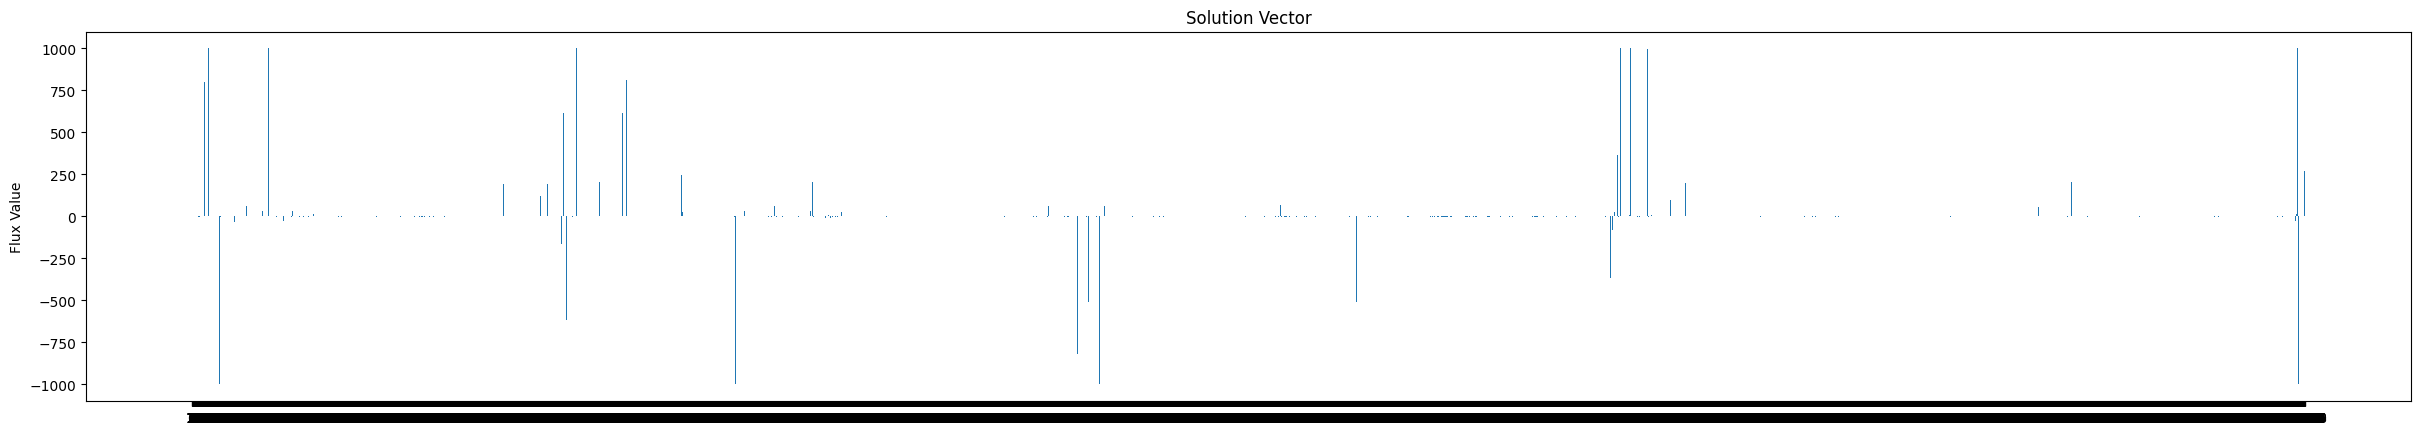

In [ ]:
# Display solution vector
v_pos = np.arange(len(solution.fluxes))
f = plt.figure()
f.set_figwidth(30)
plt.bar(v_pos, solution.fluxes, align='center')
plt.xticks(v_pos)
#f.set_figheight(8)
plt.ylabel('Flux Value')
plt.title('Solution Vector')
plt.show()

Sometimes helpful: print only nonzero fluxes

In [ ]:
# OUTPUTS OF FBA: Display all nonzero fluxes
def makeReactionDataFrame(reactions):
  reactionIDList = []
  reactionNameList = []
  fluxList = []
  metaboliteIDListList = []
  metaboliteNameListList = []
  geneRuleList = []
  geneNameList = []
  for reaction in reactions:
      reactionIDList.append(reaction.id)
      reactionNameList.append(reaction.name)
      fluxList.append(reaction.flux)
      geneRule = reaction.gene_reaction_rule
      if geneRule == "":
        geneRuleList.append("N/A")
      else:
        geneRuleList.append(geneRule)
      geneName = reaction.gene_name_reaction_rule
      if geneName == "":
        geneNameList.append("N/A")
      else:
        geneNameList.append(geneName)
      metaboliteIDList = []
      metaboliteNameList = []
      for metabolite in reaction.metabolites:
        metaboliteIDList.append(metabolite.id)
        metaboliteNameList.append(metabolite.name)
      metaboliteIDListList.append(", ".join(metaboliteIDList))
      metaboliteNameListList.append(", ".join(metaboliteNameList))
  return pd.DataFrame(data={"ReactionID": reactionIDList, "ReactionName": reactionNameList, "GeneRule": geneRuleList, "GeneName": geneNameList, "MetaboliteIDs": metaboliteIDListList, "MetaboliteNames": metaboliteNameListList, "Flux": fluxList})

reactionDF = makeReactionDataFrame(model.reactions)
reactionDF

,ReactionID,ReactionName,GeneRule,GeneName,MetaboliteIDs,MetaboliteNames,Flux
0,10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",N/A,N/A,"10fthf5glu_c, 10fthf5glu_l","10-formyltetrahydrofolate-[Glu](5), 10-formylt...",0.000000
1,10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",N/A,N/A,"10fthf5glu_c, 10fthf5glu_m","10-formyltetrahydrofolate-[Glu](5), 10-formylt...",0.000000
2,10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal",N/A,N/A,"10fthf6glu_c, 10fthf6glu_l","10-formyltetrahydrofolate-[Glu](6), 10-formylt...",0.000000
3,10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial",N/A,N/A,"10fthf6glu_c, 10fthf6glu_m","10-formyltetrahydrofolate-[Glu](6), 10-formylt...",0.000000
4,10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal",N/A,N/A,"10fthf7glu_c, 10fthf7glu_l","10-formyltetrahydrofolate-[Glu](7), 10-formylt...",0.000000
...,...,...,...,...,...,...,...
10595,CYOR_u10mi,CYOR u10mi,(7384_AT1 and 7388_AT1 and 4519_AT1 and 29796_...,(UQCRC1 and UQCRH and CYTB and UQCR10 and UQCR...,"ficytC_m, focytC_m, h_i, h_m, q10_m, q10h2_m","Ferricytochrome c, Ferrocytochrome C, H+, H+, ...",264.468899
10596,Htmi,Htmi,9016_AT1 or 7352_AT2 or 7352_AT1 or 7351_AT1 o...,SLC25A14 or UCP3 or UCP3 or UCP2 or SLC25A14 o...,"h_i, h_m","H+, H+",0.000000
10597,NADH2_u10mi,NADH2 u10mi,(4715_AT1 and 4720_AT1 and 4719_AT1 and 4700_A...,(NDUFB9 and NDUFS2 and NDUFS1 and NDUFA6 and N...,"h_i, h_m, nad_m, nadh_m, q10_m, q10h2_m","H+, H+, Nicotinamide adenine dinucleotide, Nic...",0.000000
10598,CYOOm3i,CYOOm3i,1351_AT1 and 1347_AT1 and 1329_AT1 and 1327_AT...,COX8A and COX7A2 and COX5B and COX4I1 and COX8...,"ficytC_m, focytC_m, h2o_m, h_i, h_m, o2_m, o2s_m","Ferricytochrome c, Ferrocytochrome C, H2O H2O,...",0.000000


In [ ]:
proliferationDF = reactionDF

In [ ]:
# proliferationDF = reactionDF
# proliferationDF['FluxFullMaintenance'] = fullMaintenanceDF['Flux']
proliferationDF['FluxDiffFullMaintenanceProliferation'] = proliferationDF['Flux'] - proliferationDF['FluxFullMaintenance']
cleanedDF = proliferationDF[abs(proliferationDF['FluxDiffFullMaintenanceProliferation']) > 0.1]
cleanedDF = cleanedDF[cleanedDF['GeneName'] != "N/A"]
cleanedDF

,ReactionID,ReactionName,GeneRule,GeneName,MetaboliteIDs,MetaboliteNames,Flux,FluxFullMaintenance,FluxDiffFullMaintenanceProliferation
142,ABUTt2rL,4-aminobutyrate reversible transport in via pr...,206358_AT1,SLC36A1,"4abut_c, 4abut_l, h_c, h_l","4-Aminobutanoate, 4-Aminobutanoate, H+, H+",3.000000,2.847645,0.152355
206,ACOAD9m,"2-methylacyl-coa dehydrogenase, 2-Methylprop-2...",34_AT1 or 27034_AT1,ACADM or ACAD8,"2mp2coa_m, fad_m, fadh2_m, ibcoa_m","2-Methylprop-2-enoyl-CoA, Flavin adenine dinuc...",433.878628,442.784180,-8.905552
210,ACONTm,Aconitate hydratase,50_AT1 or 48_AT1,ACO2 or ACO1,"cit_m, icit_m","Citrate, Isocitrate",841.746893,839.898959,1.847934
267,AKGDm,2-oxoglutarate dehydrogenase,(4967_AT2 and 1738_AT1 and 8050_AT1 and 1743_A...,(OGDH and DLD and PDHX and DLST) or (OGDH and ...,"akg_m, co2_m, coa_m, nad_m, nadh_m, succoa_m","2-Oxoglutarate, CO2 CO2, Coenzyme A, Nicotinam...",767.374479,750.316860,17.057618
268,AKGMALtm,Dicarboxylate/tricarboxylate carrier (mal:akg)...,8402_AT1 or 1468_AT1,SLC25A11 or SLC25A10,"akg_c, akg_m, mal__L_c, mal__L_m","2-Oxoglutarate, 2-Oxoglutarate, L-Malate, L-Ma...",141.633310,155.569677,-13.936367
...,...,...,...,...,...,...,...,...,...
9368,HMR_6977,S-Adenosyl-L-Methionine:Cytochrome-C-L-Lysine ...,55904_AT1 or 58508_AT1 or 9739_AT1 or 6839_AT1...,KMT2E or KMT2C or SETD1A or SUV39H1 or DOT1L o...,"Ndmelys_c, Ntmelys_c, ahcys_c, amet_c","Protein N6,N6-dimethyl-L-lysine, Protein N6,N6...",0.000000,1.000000,-1.000000
9369,HMR_6978,Signal Peptidase I,28972_AT1 or 9789_AT1 or 60559_AT1 or 23478_AT...,SPCS1 or SPCS2 or SPCS3 or SEC11A or SEC11C,"Ntmelys_c, h2o_c, h_c, tmlys_c","Protein N6,N6,N6-trimethyl-L-lysine, H2O H2O, ...",0.000000,1.000000,-1.000000
9427,DCYTtm,Deoxycytidine facilated transport in mitochondria,2030_AT1 or 3177_AT1,SLC29A1 or SLC29A2,"dcyt_c, dcyt_m","Deoxycytidine, Deoxycytidine",203.157004,206.101041,-2.944036
10595,CYOR_u10mi,CYOR u10mi,(7384_AT1 and 7388_AT1 and 4519_AT1 and 29796_...,(UQCRC1 and UQCRH and CYTB and UQCR10 and UQCR...,"ficytC_m, focytC_m, h_i, h_m, q10_m, q10h2_m","Ferricytochrome c, Ferrocytochrome C, H+, H+, ...",264.468899,269.592754,-5.123855


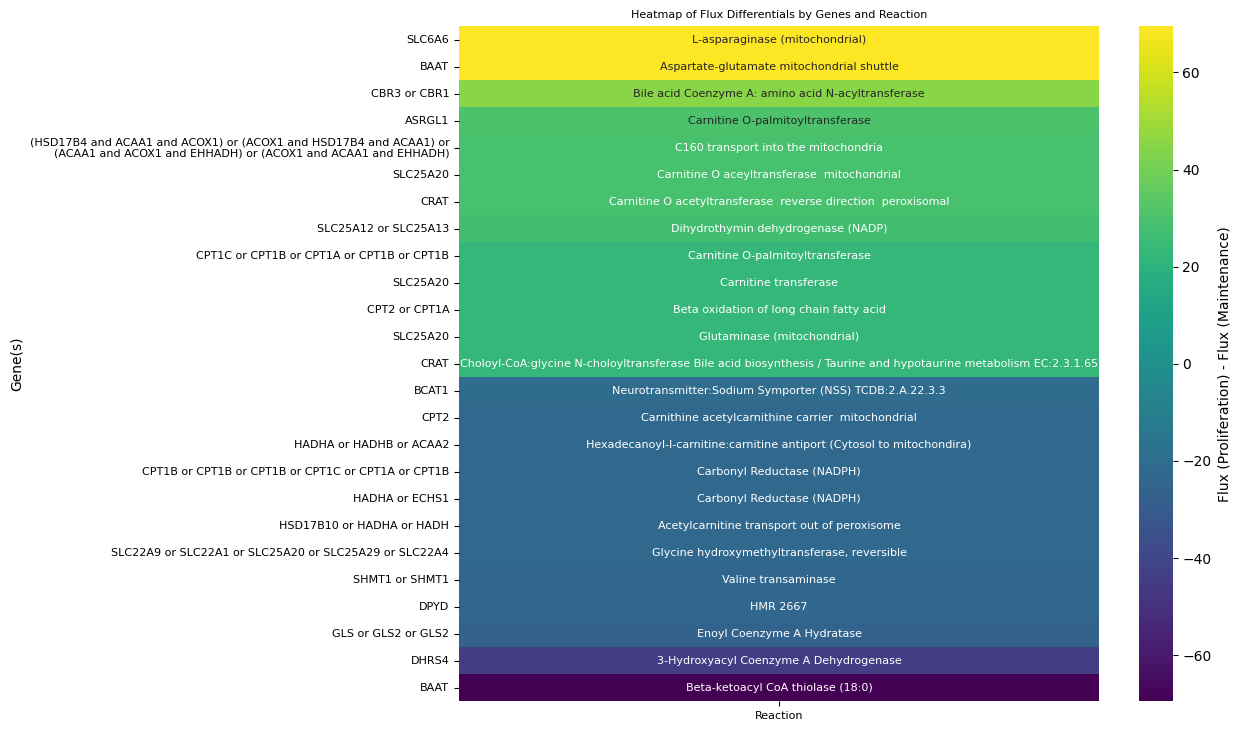

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# Generic wrapping function
def wrap_text(text, width, maxChars=255):
    if len(text) > maxChars:
      # text = text[:maxChars] + '...'
      text = textwrap.shorten(text, width=maxChars, placeholder="...")

    return textwrap.fill(str(text), width=width)

# Wrapping function for groupby ReactionName (with independent control)
# def get_wrapped_reaction(pathway_group, reaction_wrap_width):
#     if pathway_group.mode().empty:
#         name = pathway_group.iloc[0]
#     else:
#         name = pathway_group.mode().iat[0]
#     return wrap_text(name, width=reaction_wrap_width)

# Step 1: Compute average logFC per pathway
heatmap_data = cleanedDF
heatmap_data = heatmap_data.sort_values(by='FluxDiffFullMaintenanceProliferation', ascending=False)

# Step 2: Wrap pathway names for y-axis label (width = 50)
heatmap_data['GeneName'] = heatmap_data['GeneName'].apply(lambda x: wrap_text(x, width=65))
heatmap_data = heatmap_data.set_index('GeneName')

# Step 3: Build mapping of original → wrapped Pathway
# pathway_map = dict(zip(heatmap_data['Pathway'], heatmap_data.index))

# Step 4: Wrap ReactionName annotations independently (width = 30)
# reaction_labels = Age_FBA.groupby('Pathway')['ReactionName'].agg(
#     lambda x: get_wrapped_reaction(x, reaction_wrap_width=30)
# )
# reaction_labels.index = reaction_labels.index.map(pathway_map)
# reaction_labels = cleanedDF['ReactionName'].agg(
#     lambda x: wrap_text(x, width=5)
# )
reaction_labels = cleanedDF
reaction_labels = reaction_labels.reindex(cleanedDF['ReactionName'])

# Step 5: Prepare annotation array
annot_array = reaction_labels.index.values.reshape(-1, 1)
# annot_array = reaction_labels

# Step 6: Plot heatmap

# --- Key parameters ---
cell_width = 17
cell_height = 0.3  # height of each heatmap row
n_rows, n_cols = heatmap_data.shape

heatmap_height = n_rows * cell_height

label_space = 163  # space for y-axis labels

fig_width = label_space + cell_width
fig_height = heatmap_height

# Create fixed-size figure
fig = plt.figure(figsize=(fig_width, fig_height))

# Manually place heatmap axes, leaving room for labels
left_margin_frac = label_space / fig_width
ax = fig.add_axes([left_margin_frac, 0.05, 1 - left_margin_frac - 0.05, 0.9])
sns.heatmap(heatmap_data[['FluxDiffFullMaintenanceProliferation']], annot=annot_array, fmt='',
            cmap='viridis', cbar_kws={'label': 'Flux (Proliferation) - Flux (Maintenance)'}, ax=ax, xticklabels=['Reaction'],
            annot_kws={'fontsize': 8},)
plt.title('Heatmap of Flux Differentials by Genes and Reaction', fontsize=8)

# Format y-tick labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelsize=8)

plt.ylabel('Gene(s)')
plt.show()


In [ ]:
proliferationDF[abs(proliferationDF['FluxDiffFullMaintenanceProliferation']) > 1]

NameError: name 'proliferationDF' is not defined

In [ ]:
# TumorVsNormalRelatedGenesTable = pd.read_csv('/content/gdrive/MyDrive/BiologicalNetworks/related_genes_from_top100_TumorvsNormal.csv', sep = ',')
HighAgeVsLowAgeRelatedGenesTable = pd.read_csv('/content/gdrive/MyDrive/BiologicalNetworks/related_genes_from_top100_Age60.csv', sep = ',')

display(HighAgeVsLowAgeRelatedGenesTable)

,Gene of Interest,logFC (1st gene),Related Gene,Pathway,logFC (Related Gene)
0,AREG,-1.245640,CAMK2G,Colorectal cancer; ErbB signaling pathway; Hip...,0.010812
1,AREG,-1.245640,ITGA1,Colorectal cancer; ErbB signaling pathway; Hip...,-0.197611
2,AREG,-1.245640,HRAS,Colorectal cancer; ErbB signaling pathway; Hip...,-0.040200
3,AREG,-1.245640,THBS3,Colorectal cancer; ErbB signaling pathway; Hip...,-0.065635
4,AREG,-1.245640,LATS2,Colorectal cancer; ErbB signaling pathway; Hip...,-0.118822
...,...,...,...,...,...
6923,H3C8,-0.774389,HLA-DQB1,Alcoholism; Neutrophil extracellular trap form...,0.061856
6924,H3C8,-0.774389,PLAU,Alcoholism; Neutrophil extracellular trap form...,-0.141643
6925,H3C8,-0.774389,FUT8,Alcoholism; Neutrophil extracellular trap form...,-0.084112
6926,H3C8,-0.774389,CGAS,Alcoholism; Neutrophil extracellular trap form...,-0.048079


In [ ]:
primaryGenesDF = HighAgeVsLowAgeRelatedGenesTable.drop_duplicates(subset=['Gene of Interest'])
primaryGenesDF['Related Gene'] = primaryGenesDF['Gene of Interest']
primaryGenesDF['logFC (1st gene)'] = primaryGenesDF['logFC (Related Gene)']
primaryGenesDF
ageComparisonDF = pd.concat([primaryGenesDF, HighAgeVsLowAgeRelatedGenesTable])
ageComparisonDF
# for gene in HighAgeVsLowAgeRelatedGenesTable['Gene of Interest']:
#   if gene not in genesObserved
#     genesObserved.add(gene)


<ipython-input-90-a7ad344ddc65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primaryGenesDF['Related Gene'] = primaryGenesDF['Gene of Interest']
<ipython-input-90-a7ad344ddc65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primaryGenesDF['logFC (1st gene)'] = primaryGenesDF['logFC (Related Gene)']


,Gene of Interest,logFC (1st gene),Related Gene,Pathway,logFC (Related Gene)
0,AREG,0.010812,AREG,Colorectal cancer; ErbB signaling pathway; Hip...,0.010812
622,COL17A1,-0.098783,COL17A1,Protein digestion and absorption,-0.098783
689,IL20,0.059002,IL20,Cytokine-cytokine receptor interaction; JAK-ST...,0.059002
941,SERPINB5,-0.040200,SERPINB5,MicroRNAs in cancer; p53 signaling pathway,-0.040200
1146,SLC27A6,0.048247,SLC27A6,Insulin resistance; PPAR signaling pathway,0.048247
...,...,...,...,...,...
6923,H3C8,-0.774389,HLA-DQB1,Alcoholism; Neutrophil extracellular trap form...,0.061856
6924,H3C8,-0.774389,PLAU,Alcoholism; Neutrophil extracellular trap form...,-0.141643
6925,H3C8,-0.774389,FUT8,Alcoholism; Neutrophil extracellular trap form...,-0.084112
6926,H3C8,-0.774389,CGAS,Alcoholism; Neutrophil extracellular trap form...,-0.048079


In [ ]:
# fullMaintenanceDF = reactionDF
relatedGenes = TumorVsNormalRelatedGenesTable['Related Gene']
relatedGenes

,Related Gene
0,COL9A3
1,SLC36A4
2,CPB1
3,COL11A1
4,ATP1B2
...,...
13239,JUN
13240,UQCR11
13241,CREB5
13242,ERN1


In [ ]:
# comparisonDF = pd.merge(proliferationDF, TumorVsNormalRelatedGenesTable, left_on='GeneName', right_on='Related Gene')
# ageComparisonDF = pd.merge(proliferationDF, HighAgeVsLowAgeRelatedGenesTable, left_on='GeneName', right_on='Related Gene')
ageComparisonDF = pd.merge(proliferationDF, ageComparisonDF, left_on='GeneName', right_on='Related Gene')
ageComparisonDF
#  proliferationDF[proliferationDF['GeneName'].isin(relatedGenes)]

,ReactionID,ReactionName,GeneRule,GeneName,MetaboliteIDs,MetaboliteNames,Flux,FluxFullMaintenance,FluxDiffFullMaintenanceProliferation,Gene of Interest,logFC (1st gene),Related Gene,Pathway,logFC (Related Gene)
0,25VITD2Hm,1-alpha-Vitamin D-25-hydroxylase (D2),1594_AT1,CYP27B1,"1a25dhvitd2_m, 25hvitd2_m, h2o_m, h_m, nadp_m,...","1-alpha,25-Dihydroxyvitamin D2, 25-Hydroxyvita...",0.0,0.0,0.0,SLC34A2,-0.917444,CYP27B1,Mineral absorption; Parathyroid hormone synthe...,0.047384
1,25VITD2Hm,1-alpha-Vitamin D-25-hydroxylase (D2),1594_AT1,CYP27B1,"1a25dhvitd2_m, 25hvitd2_m, h2o_m, h_m, nadp_m,...","1-alpha,25-Dihydroxyvitamin D2, 25-Hydroxyvita...",0.0,0.0,0.0,TNFSF11,-0.874282,CYP27B1,Breast cancer; Chemical carcinogenesis; Cytoki...,0.047384
2,25VITD3Hm,1-alpha-Vitamin D-25-hydroxylase (D3),1594_AT1,CYP27B1,"1a25dhvitd3_m, 25hvitd3_m, h2o_m, h_m, nadp_m,...","1-alpha,25-Dihydroxyvitamin D3, 25-Hydroxyvita...",0.0,0.0,0.0,SLC34A2,-0.917444,CYP27B1,Mineral absorption; Parathyroid hormone synthe...,0.047384
3,25VITD3Hm,1-alpha-Vitamin D-25-hydroxylase (D3),1594_AT1,CYP27B1,"1a25dhvitd3_m, 25hvitd3_m, h2o_m, h_m, nadp_m,...","1-alpha,25-Dihydroxyvitamin D3, 25-Hydroxyvita...",0.0,0.0,0.0,TNFSF11,-0.874282,CYP27B1,Breast cancer; Chemical carcinogenesis; Cytoki...,0.047384
4,34DHPHEt,"3,4-Dihydroxy-L-phenylalanine transport",117247_AT1,SLC16A10,"34dhphe_c, 34dhphe_e","3,4-Dihydroxy-L-phenylalanine, 3,4-Dihydroxy-L...",0.0,0.0,0.0,COL17A1,-1.088748,SLC16A10,Protein digestion and absorption,-0.199668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,SMVtu,Efflux of simvastatin by P-gp from the enteroc...,5243_AT1,ABCB1,"adp_c, atp_c, h2o_c, h_c, pi_c, smv_c, smv_e","ADP C10H12N5O10P2, ATP C10H12N5O13P3, H2O H2O,...",0.0,0.0,0.0,TP63,-0.957668,ABCB1,MicroRNAs in cancer,-0.289674
810,SMVtu,Efflux of simvastatin by P-gp from the enteroc...,5243_AT1,ABCB1,"adp_c, atp_c, h2o_c, h_c, pi_c, smv_c, smv_e","ADP C10H12N5O10P2, ATP C10H12N5O13P3, H2O H2O,...",0.0,0.0,0.0,TNN,-0.782265,ABCB1,ECM-receptor interaction; Focal adhesion; Huma...,-0.289674
811,TACRtu,Efflux of tacrolimus into intestinal lumen by ...,5243_AT1,ABCB1,"adp_c, atp_c, h2o_c, h_c, pi_c, tacr_c, tacr_e","ADP C10H12N5O10P2, ATP C10H12N5O13P3, H2O H2O,...",0.0,0.0,0.0,SERPINB5,-0.965390,ABCB1,MicroRNAs in cancer; p53 signaling pathway,-0.289674
812,TACRtu,Efflux of tacrolimus into intestinal lumen by ...,5243_AT1,ABCB1,"adp_c, atp_c, h2o_c, h_c, pi_c, tacr_c, tacr_e","ADP C10H12N5O10P2, ATP C10H12N5O13P3, H2O H2O,...",0.0,0.0,0.0,TP63,-0.957668,ABCB1,MicroRNAs in cancer,-0.289674


In [ ]:
# OUTPUTS OF FBA: Display all nonzero fluxes
def makeMetabolitesDataFrame(reactions):
  reactionIDList = []
  reactionNameList = []
  fluxList = []
  metaboliteIDList = []
  metaboliteNameList = []
  for reaction in reactions:
    reactionID = reaction.id
    reactionName = reaction.name
    reactionFlux = reaction.flux
    for metabolite in reaction.metabolites:
      metaboliteIDList.append(metabolite.id)
      metaboliteNameList.append(metabolite.name)
      reactionIDList.append(reactionID)
      reactionNameList.append(reactionName)
      fluxList.append(reactionFlux)

  return pd.DataFrame(data={"MetaboliteID": metaboliteIDList, "MetaboliteName": metaboliteNameList, "ReactionID": reactionIDList, "ReactionName": reactionNameList, "Flux": fluxList})

makeMetabolitesDataFrame(model.reactions)

,MetaboliteID,MetaboliteName,ReactionID,ReactionName,Flux
0,10fthf5glu_c,10-formyltetrahydrofolate-[Glu](5),10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",0.000000
1,10fthf5glu_l,10-formyltetrahydrofolate-[Glu](5),10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",0.000000
2,10fthf5glu_c,10-formyltetrahydrofolate-[Glu](5),10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",0.000000
3,10fthf5glu_m,10-formyltetrahydrofolate-[Glu](5),10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",0.000000
4,10fthf6glu_c,10-formyltetrahydrofolate-[Glu](6),10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal",0.000000
...,...,...,...,...,...
40420,focytC_m,Ferrocytochrome C,CYOOm2i,CYOOm2i,38.455669
40421,h2o_m,H2O H2O,CYOOm2i,CYOOm2i,38.455669
40422,h_i,H+,CYOOm2i,CYOOm2i,38.455669
40423,h_m,H+,CYOOm2i,CYOOm2i,38.455669
